## Portfolio-analysis-2
by Jean, Alex, Jessica

### Import Packages

In [36]:
import yfinance as yf
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

### Tickers + ETFS

In [ ]:
# Tickers
tickers = ["NVDA", "NFLX", "GME", "BB", "NOK", "AMZN", "TSLA"]
etfs = ["SPY", "IWM", "DIA"]

### Declaring Function to Download/Import Data

In [37]:
class DataDownloader:
    """
    DataDownloader is a class designed to fetch historical stock and ETF data.
    
    Attributes:
    - tickers: A list of stock tickers.
    - etfs: A list of ETF tickers.
    
    Methods:
    - download(period): Downloads historical data for the given period. Combines tickers and etfs.
    - quarterly(): Downloads data for the past 3 months.
    - annual(): Downloads data for the past year.
    - decade(): Downloads data for the past 10 years.
    
    """
    def __init__(self, tickers, etfs):
        self.tickers = tickers
        self.etfs = etfs

    def download(self, period='1y'):
        return yf.download(self.tickers + self.etfs, period=period)

    def quarterly(self):
        return self.download(period='3mo')

    def annual(self):
        return self.download(period='1y')
    
    def decade(self):
        return self.download(period='10y')
    

"""
After defining the class, an instance of the DataDownloader is created using the provided tickers and ETFs. 
The historical data for the tickers and ETFs is then fetched for the three time periods and stored in 
`quarterly_data`, `annual_data`, and `decade_data`.
"""

downloader = DataDownloader(tickers, etfs)
# Usage Guide:
quarterly_data = downloader.quarterly()
annual_data = downloader.annual()
decade_data = downloader.decade()


[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed


In [ ]:
# Trading days = count of rows per period
TRADING_DAYS_QUARTER = quarterly_data['Adj Close']['NVDA'].count()
TRADING_DAYS_ANNUAL = annual_data['Adj Close']['NVDA'].count()
TRADING_DAYS_DECADE = decade_data['Adj Close']['NVDA'].count()

# Part 1
Create a table showing constituent (stocks) risk analysis in the equal-weight portfolio analysis as of the current date.

In [39]:
# Utility functions for financial calculations:

def calculate_weights(prices):
    """Computes the weightage of each stock based on its price relative to the total price of all stocks."""
    total_price = prices.sum()
    return (prices / total_price) * 100

def calculate_annualized_volatility(ticker_data):
    """Calculates the annualized volatility for a given stock using its daily returns."""
    daily_return = ticker_data.pct_change().dropna()
    std_dev = daily_return.std()
    return std_dev * math.sqrt(TRADING_DAYS_QUARTER) * 100

def calculate_beta(stock, etf, returns):
    """Computes the beta value of a stock relative to a specified ETF."""
    covariance = returns[stock].cov(returns[etf])
    variance = returns[etf].var()
    return str(round(covariance / variance,2))

In [40]:
# Column 1 – Ticker
table1 = pd.DataFrame(index=tickers)

# Column 2 – Portfolio Weight (equally weighted)
# calc_weight = calculate_weights(quarterly_data['Adj Close'][tickers].iloc[-1])
# weight = calc_weight.round(2).astype(str) + "%"
# table1['Weight'] = weight
n = len(tickers)
weight = 1/n
table1['Portfolio Weight'] = weight

# Column 3 – Annualized Volatility (using trailing 3-months)
calc_vol = calculate_annualized_volatility(quarterly_data['Adj Close'][tickers])
volatility = calc_vol.round(2).astype(str) + "%"
table1['Annualized Volatility'] = volatility

# Column 4 – Beta against SPY (using trailing 12-months)
# Column 5 – Beta against IWM (using trailing 12-months)
# Column 6 – Beta against DIA (using trailing 12-months
returns = annual_data['Adj Close'].pct_change().dropna()
for etf in etfs:
    table1[f'Beta against {etf}'] = [calculate_beta(stock, etf, returns) for stock in tickers]

# Column 7 – Average Weekly Drawdown (52-week Low minus 52-week High) / 52-week High
# Column 8 – Maximum Weekly Drawdown (52-week Low minus 52-week High) / 52-week High

# 7-8.Calculate average and maximum weekly drawdown
highs = annual_data['High'][tickers].pct_change().dropna()
lows = annual_data['Low'][tickers].pct_change().dropna()
table1['Average Weekly Drawdown'] = (((lows.mean() - highs.mean()) / highs.mean()) * 100).round(2)
table1['Maximum Weekly Drawdown'] = (((lows.min() - highs.max()) / highs.max()) * 100).round(2)

# Column 9 – Total Return (using trailing 10-years)
# Column 10 – Annualized Total Return (using trailing 10-years)
initial_values = decade_data['Adj Close'][tickers].dropna().iloc[0]
current_values = decade_data['Adj Close'][tickers].iloc[-1]
table1['Total Return'] = (((current_values - initial_values) / initial_values) * 100).round(2).astype(str) + "%"
table1['Annualized Total Return'] = ((((current_values / initial_values) ** (1/10)) - 1) * 100).round(2).astype(str) + "%"

## Part One Results

In [41]:
table1

,Portfolio Weight,Annualized Volatility,Beta against SPY,Beta against IWM,Beta against DIA,Average Weekly Drawdown,Maximum Weekly Drawdown,Total Return,Annualized Total Return
NVDA,0.142857,19.82%,2.15,1.3,1.88,0.34,-128.46,12310.88%,61.95%
NFLX,0.142857,17.32%,1.43,0.94,1.39,2.41,-176.71,727.52%,23.53%
GME,0.142857,21.53%,1.63,1.44,1.67,63.71,-142.06,72.51%,5.6%
BB,0.142857,34.18%,1.6,1.22,1.56,-42.44,-207.67,-43.08%,-5.48%
NOK,0.142857,12.53%,1.11,0.82,1.23,-10.33,-319.96,-26.79%,-3.07%
AMZN,0.142857,16.09%,1.54,0.99,1.34,6.12,-203.87,722.6%,23.46%
TSLA,0.142857,24.56%,1.89,1.36,1.59,27.15,-205.75,2077.6%,36.08%


# Part 2
Create a table showing Portfolio Risk against the three ETFs

In [43]:
"""
This code computes the daily percentage change for the adjusted close prices, 
removes any missing values, and calculates the daily total value of the portfolio.
"""

# Calculate the percentage change for the adjusted close and drop NaN values.
annual_data_complete = annual_data['Adj Close'].pct_change().dropna()
annual_data_complete['portfolio'] = annual_data_complete[tickers].sum(axis=1)

"""
This code block defines functions to calculate various financial metrics:
1. Portfolio correlation with each ETF.
2. Portfolio covariance with each ETF.
3. Tracking error for each ETF over a specified period.
4. Sharpe ratio for each ETF.
5. Annualized volatility spread between the portfolio and each ETF.

Additionally, it preprocesses the annual data by 
calculating percentage changes and computing the portfolio's total value for each day.
"""

# Column 2 – Correlation against ETF
def calculate_portfolio_correlation(data, etfs, portfolio):
    return [round(data[etf].corr(data[portfolio]), 2) for etf in etfs]

# Column 3 – Covariance of Portfolio against ETF
def calculate_portfolio_covariance(data, etfs, portfolio):
    return [round(data[[etf, portfolio]].cov().loc[etf, portfolio] * 100, 2) for etf in etfs]

# Column 4 – Tracking Errors (using trailing 10-years)
def calculate_tracking_error(data, etfs, tickers, trading_days):
    errors = []
    for etf in etfs:
        data['total_pct_change_tickers'] = data['Adj Close'][tickers + [etf]].sum(axis=1)
        data['TE'] = data['total_pct_change_tickers'] - data['Adj Close'][etf]
        te = (data['TE'].std() * 100) * math.sqrt(trading_days)
        errors.append(round(te, 2))
    return errors

# Column 5 – Sharpe Ratio (using current risk-free rate)
def calculate_sharpe_ratio(data, etfs, tickers):
    ratios = []
    for etf in etfs:
        data['total_pct_change_tickers'] = data[tickers + [etf]].sum(axis=1)
        daily_return_mean = data['total_pct_change_tickers'].mean()
        daily_return_stdev = data['total_pct_change_tickers'].std()
        ratio = (daily_return_mean / daily_return_stdev) * 100
        ratios.append(round(ratio, 2))
    return ratios

# Column 6 – Annualized Volatility (252 days) Spread (Portfolio Volatility – ETF Volatility)
def calculate_ann_vol_spread(data, etfs, tickers, trading_days):
    spreads = []
    for etf in etfs:
        port_voli = (data[tickers].sum(axis=1).std()) * math.sqrt(trading_days)
        etf_voli = (data[etf].std()) * math.sqrt(trading_days)
        spreads.append(round((port_voli - etf_voli) * 100, 2))
    return spreads

In [44]:
# Column 1 – ETF Ticker
table2 = pd.DataFrame(index=etfs)

# Column 2 – Correlation against ETF
table2['Correlation against ETF'] = calculate_portfolio_correlation(annual_data_complete, etfs, 'portfolio')

# Column 3 – Covariance of Portfolio against ETF
table2['Covariance against ETF'] = calculate_portfolio_covariance(annual_data_complete, etfs, 'portfolio')

# Column 4 – Tracking Errors (using trailing 10-years)
table2['Tracking Errors'] = calculate_tracking_error(decade_data.copy(), etfs, tickers, TRADING_DAYS_DECADE)

# Column 5 – Sharpe Ratio (using current risk-free rate)
table2['Sharpe Ratio'] = calculate_sharpe_ratio(annual_data_complete, etfs, tickers)

#5: Column 6 – Annualized Volatility (252 days) Spread (Portfolio Volatility – ETF Volatility)
table2['Annualized Volatility Spread'] = calculate_ann_vol_spread(annual_data_complete, etfs, tickers, TRADING_DAYS_ANNUAL)

## Part Two Results

In [45]:
table2

,Correlation against ETF,Covariance against ETF,Tracking Errors,Sharpe Ratio,Annualized Volatility Spread
SPY,0.79,0.13,1996595.56,5.78,224.75
IWM,0.71,0.15,1996595.56,5.44,220.22
DIA,0.62,0.08,1996595.56,5.81,227.45


# Part 3
Create a correlation matrix showing the correlations between the equal-weighted portfolio, 3 ETFs, and your 7 stocks.

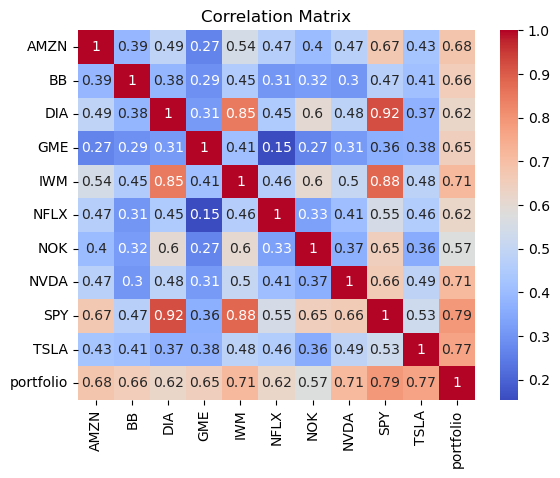

In [46]:
# Correlation Matrix
corr_matrix = annual_data_complete.drop(columns='total_pct_change_tickers').corr(method="pearson")

# Plot Heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()